In [1]:
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
import os
import sys
import pickle
import json
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from matplotlib import image as mpimg
import torch
from scipy.stats import zscore
from rnn_coach.src.Task import TaskCDDM, TaskCDDMplus
from rnn_coach.src.RNN_torch import RNN_torch
from rnn_coach.src.RNN_numpy import RNN_numpy
from scipy.sparse.linalg import lsqr
from copy import deepcopy
from sklearn.decomposition import PCA
import pandas as pd
import datetime
import pickle

In [2]:
task_name = "CDDMplus"
RNNs_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name)

In [3]:
RNNs = []
for folder in os.listdir(os.path.join('../', "data", "trained_RNNs", task_name)):
    if (folder == '.DS_Store'):
        pass
    else:
        if "relu" in folder:
            RNNs.append(folder)

In [4]:
len(RNNs)

88

In [5]:
RNNs = [
    "0.0397083_CDDMplus;relu;N=66;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.0394402_CDDMplus;relu;N=59;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.0388199_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.036835_CDDMplus;relu;N=61;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.0356931_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.0273963_CDDMplus;relu;N=65;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.0234536_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.0213185_CDDMplus;relu;N=62;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.0186039_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.015914_CDDMplus;relu;N=62;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.0126494_CDDMplus;relu;N=64;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.0117763_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.0107358_CDDMplus;relu;N=60;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.0094972_CDDMplus;relu;N=66;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
    "0.0085129_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000",
]

In [6]:
names = []
scores = []
Ns = []
lmbdos = []
lmbdrs = []
lrs = []
activations = []
tags = []
maxiters = []
for folder in RNNs:
    day = float(datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%d'))
    month = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%m')
    if (month == '04') and (day > 24):
        files = os.listdir(os.path.join(RNNs_path, folder))
        config_file = None
        for file in files:
            if "config" in file:
                config_file = file
        config_data = json.load(open(os.path.join(RNNs_path, folder, config_file), "rb+"))
        score = np.round(float(config_file.split("_")[0]), 7)
        activation = config_data["activation"]
        N = config_data["N"]
        lmbdo = config_data["lambda_orth"]
        lmbdr = config_data["lambda_r"]
        lr=config_data["lr"]
        maxiter=config_data["max_iter"]
        extra_info = f"{task_name};{activation};N={N};lmbdo={lmbdo};lmbdr={lmbdr};lr={lr};maxiter={maxiter}"
        name = f"{score}_{extra_info}"
        tag = config_data["tag"]
        names.append(name)
        scores.append(score)
        Ns.append(N)
        lmbdos.append(lmbdo)
        lmbdrs.append(lmbdr)
        lrs.append(lr)
        tags.append(tag)
        activations.append(activation)
        maxiters.append(maxiter)

In [7]:
df = pd.DataFrame({"name" : names, "scores" : scores, "N" : Ns, "activation": activations, "lmbdo" : lmbdos, "lmbdr": lmbdrs, "lr" : lrs, "maxiter" : maxiters})

In [8]:
df

,name,scores,N,activation,lmbdo,lmbdr,lr,maxiter
0,0.0397083_CDDMplus;relu;N=66;lmbdo=0.3;lmbdr=0...,0.039708,66,relu,0.3,0.3,0.005,3000
1,0.0394402_CDDMplus;relu;N=59;lmbdo=0.3;lmbdr=0...,0.039440,59,relu,0.3,0.3,0.005,3000
2,0.0388199_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0...,0.038820,63,relu,0.3,0.3,0.005,3000
3,0.036835_CDDMplus;relu;N=61;lmbdo=0.3;lmbdr=0....,0.036835,61,relu,0.3,0.3,0.005,3000
4,0.0356931_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0...,0.035693,63,relu,0.3,0.3,0.005,3000
5,0.0273963_CDDMplus;relu;N=65;lmbdo=0.3;lmbdr=0...,0.027396,65,relu,0.3,0.3,0.005,3000
6,0.0234536_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0...,0.023454,63,relu,0.3,0.3,0.005,3000
7,0.0213185_CDDMplus;relu;N=62;lmbdo=0.3;lmbdr=0...,0.021319,62,relu,0.3,0.3,0.005,3000
8,0.0186039_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0...,0.018604,63,relu,0.3,0.3,0.005,3000
9,0.015914_CDDMplus;relu;N=62;lmbdo=0.3;lmbdr=0....,0.015914,62,relu,0.3,0.3,0.005,3000


In [9]:
# additional filtering
df = df[df['lr'] == 0.005]
df = df[df['maxiter'] == 3000]

In [10]:
pd.set_option('display.max_rows', None)
df.sort_values("scores")

,name,scores,N,activation,lmbdo,lmbdr,lr,maxiter
14,0.0085129_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0...,0.008513,63,relu,0.3,0.3,0.005,3000
13,0.0094972_CDDMplus;relu;N=66;lmbdo=0.3;lmbdr=0...,0.009497,66,relu,0.3,0.3,0.005,3000
12,0.0107358_CDDMplus;relu;N=60;lmbdo=0.3;lmbdr=0...,0.010736,60,relu,0.3,0.3,0.005,3000
11,0.0117763_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0...,0.011776,63,relu,0.3,0.3,0.005,3000
10,0.0126494_CDDMplus;relu;N=64;lmbdo=0.3;lmbdr=0...,0.012649,64,relu,0.3,0.3,0.005,3000
9,0.015914_CDDMplus;relu;N=62;lmbdo=0.3;lmbdr=0....,0.015914,62,relu,0.3,0.3,0.005,3000
8,0.0186039_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0...,0.018604,63,relu,0.3,0.3,0.005,3000
7,0.0213185_CDDMplus;relu;N=62;lmbdo=0.3;lmbdr=0...,0.021319,62,relu,0.3,0.3,0.005,3000
6,0.0234536_CDDMplus;relu;N=63;lmbdo=0.3;lmbdr=0...,0.023454,63,relu,0.3,0.3,0.005,3000
5,0.0273963_CDDMplus;relu;N=65;lmbdo=0.3;lmbdr=0...,0.027396,65,relu,0.3,0.3,0.005,3000


In [11]:
top_RNNs = df.sort_values("scores")["name"].tolist()

# loading the RNNs and decoding information from them

In [12]:
num_rnn = 14
RNN_subfolder = top_RNNs[num_rnn]
RNN_score = float(top_RNNs[num_rnn].split("_")[0])
RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name, RNN_subfolder)
os.listdir(RNN_path)

['0.0397083_LA_RHS.png',
 '0.0397083_config.json',
 '0.0397083_fp_data.json',
 '0.0397083_train&valid_loss.png',
 '0.0397083_psychometric_data.png',
 '0.0397083_params_CDDMplus.json',
 '0.0397083_LA_data.pkl',
 '0.0397083_random_trials.png',
 '0.0397083_LA_3D.png',
 '0.0397083_psycho_data.json']

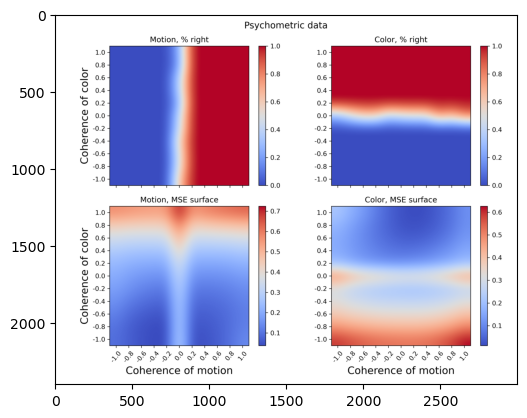

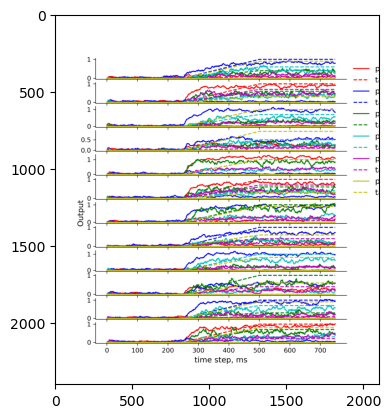

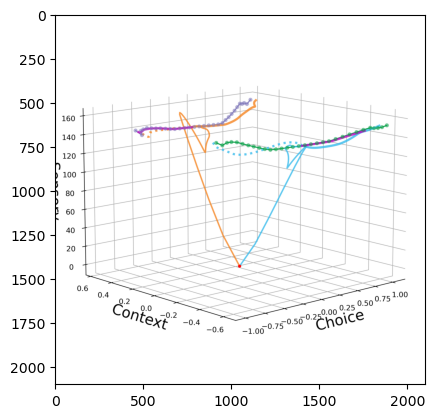

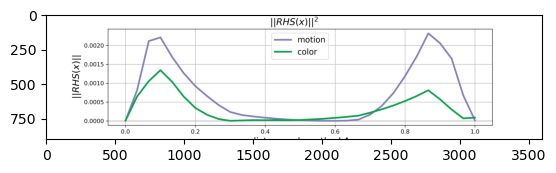

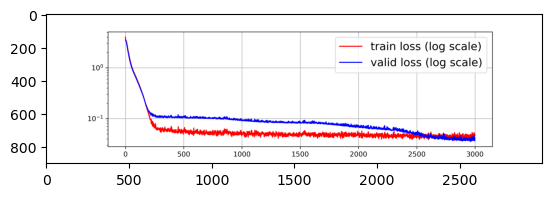

In [13]:
img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_psychometric_data.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_random_trials.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_LA_3D.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_LA_RHS.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_train&valid_loss.png"), 'rb+'))
plt.imshow(img)
plt.show()


In [14]:
RNN_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_{task_name}.json"), "rb+"))
RNN_config_file = json.load(open(os.path.join(RNN_path, f"{RNN_score}_config.json"), "rb+"))

In [15]:
W_out = np.array(RNN_data["W_out"])
W_rec = np.array(RNN_data["W_rec"])
W_inp = np.array(RNN_data["W_inp"])
bias_rec = np.array(RNN_data["bias_rec"])
y_init = np.array(RNN_data["y_init"])
activation = RNN_config_file["activation"]
mask = np.array(RNN_config_file["mask"])
input_size = RNN_config_file["num_inputs"]
output_size = RNN_config_file["num_outputs"]
task_params = RNN_config_file["task_params"]
n_steps = task_params["n_steps"]
sigma_inp = RNN_config_file["sigma_inp"]
sigma_rec = RNN_config_file["sigma_rec"]
dt = RNN_config_file["dt"]
tau = RNN_config_file["tau"]

In [16]:
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
seed = np.random.randint(1000000)
print(f"seed: {seed}")
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)

    
if activation == 'relu':
    activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
elif activation == 'tanh':
    activation_RNN = torch.tanh
elif activation == 'sigmoid':
    activation_RNN = lambda x: 1/(1 + torch.exp(-x))
elif activation == 'softplus':
    activation_RNN = lambda x: torch.log(1 + torch.exp(5 * x))
    
RNN = RNN_torch(N=W_rec.shape[0], dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                activation=activation_RNN, random_generator=rng, device=device,
                sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": W_inp,
              "W_rec": W_rec,
              "W_out": W_out,
              "b_rec": None,
              "y_init": np.zeros(W_rec.shape[0])}
RNN.set_params(RNN_params)

seed: 110576
Using cpu for RNN!


/Users/tolmach/Documents/GitHub/rnn_coach/jupyter/../../rnn_coach/src/RNN_torch.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tnsr = torch.normal(torch.tensor(mean).to(device), torch.tensor(std).to(device),


In [17]:
input_batch, target_batch, conditions_batch = task.get_batch()
n_trials = len(conditions_batch)
RNN.sigma_rec = RNN.sigma_inp = torch.tensor(0, device=RNN.device)
y, predicted_output_rnn = RNN(torch.from_numpy(input_batch.astype("float32")))
Y = np.hstack([y.detach().numpy()[:, :, i] for i in range(y.shape[-1])])

# TDR

In [18]:
Z = zscore(Y, axis = 1)
z = Z.reshape(-1, n_trials, n_steps)
z = np.swapaxes(z, 1, 2)

# PCA on Z
pca = PCA(n_components=20)
pca.fit(Z.T)
PCs = pca.components_
D = PCs.T @ PCs
Z_pca = D @ Z
z_pca = Z_pca.reshape(-1, n_trials, n_steps)
z_pca = np.swapaxes(z_pca, 1, 2)

In [19]:
choice = np.array([conditions_batch[i]['correct_choice'] for i in range(len(conditions_batch))])
motion_coh = np.array([conditions_batch[i]['motion_coh'] for i in range(len(conditions_batch))])
color_coh = np.array([conditions_batch[i]['color_coh'] for i in range(len(conditions_batch))])
context = np.array([(1 if conditions_batch[i]['context']=='motion' else -1) for i in range(len(conditions_batch))])

In [20]:
F = np.hstack([choice.reshape(-1, 1),
               motion_coh.reshape(-1, 1),
               color_coh.reshape(-1, 1),
               context.reshape(-1, 1),
               np.ones((n_trials, 1))])
B = np.zeros((Z.shape[0], n_steps, F.shape[1]))

for i in range(Z.shape[0]):
    for t in range(n_steps):
        betas_i_t = lsqr(F, z_pca[i, t, :], damp=1000)[0]
        B[i, t, :] = deepcopy(betas_i_t)
        
ind_cont = np.argmax(np.linalg.norm(B[:, :, 0], axis=0))
ind_motion = np.argmax(np.linalg.norm(B[:, :, 1], axis=0))
ind_color = np.argmax(np.linalg.norm(B[:, :, 2], axis=0))
ind_choice = np.argmax(np.linalg.norm(B[:, :, 3], axis=0))
context_direction = B[:, ind_cont, 0]
motion_direction = B[:, ind_motion, 1]
color_direction = B[:, ind_color, 2]
choice_direction = B[:, ind_choice, 3]
B_max = np.hstack([context_direction.reshape(-1, 1),
                   motion_direction.reshape(-1, 1),
                   color_direction.reshape(-1, 1),
                   choice_direction.reshape(-1,1)])
U, s, V = np.linalg.svd(B_max)
B_orth = U[:, :V.shape[0]] @ V

In [21]:
TDR_decoded_vars = (B_orth.T @ Z_pca).reshape(-1, n_trials, n_steps)
TDR_decoded_vars = np.swapaxes(TDR_decoded_vars, 1, 2)

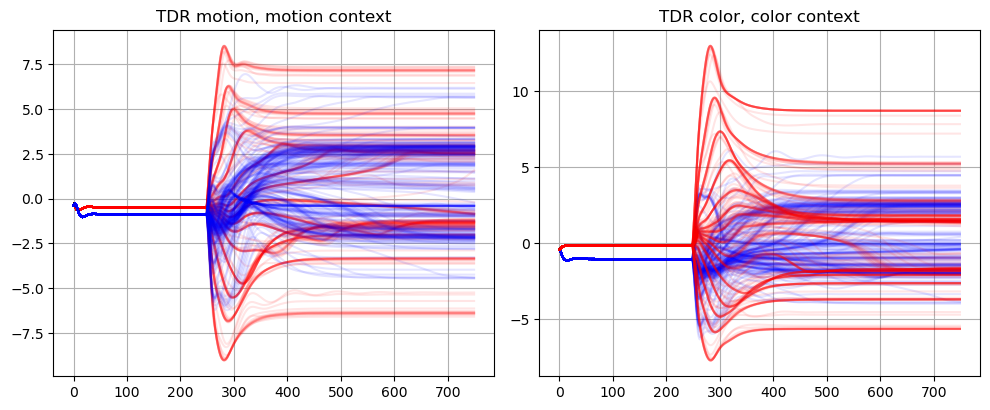

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(TDR_decoded_vars[1, 0:, :225], color='r', alpha=0.1, label = 'relevant')
ax[0].plot(TDR_decoded_vars[1, 0:, 225:], color='b', alpha=0.1, label = 'irrelevant')
# ax[0].set_ylim([-15, 15])
ax[1].plot(TDR_decoded_vars[2, 0:, :225], color='b', alpha=0.1)
ax[1].plot(TDR_decoded_vars[2, 0:, 225:], color='r', alpha=0.1)
# ax[1].set_ylim([-15, 15])

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax[0].title.set_text('TDR motion, motion context')
ax[1].title.set_text('TDR color, color context')
ax[0].grid(True)
ax[1].grid(True)
plt.show()

# Standard decoding

In [23]:
T_inp = np.hstack([input_batch[:, :, i] for i in range(input_batch.shape[-1])])
T_out_masked = np.hstack([target_batch[:, mask, i] for i in range(target_batch.shape[-1])])

In [24]:
A = np.zeros((RNN.N, 8))
for i in range(6):
    a = lsqr(Y.T, T_inp[i, :], damp=100)[0]
    A[:, i] = deepcopy(a)

Y_masked = np.hstack([y.detach().numpy()[:, mask, i] for i in range(y.shape[-1])])
for i in range(2):
    a = lsqr(Y_masked.T, T_out_masked[i, :], damp=100)[0]
    A[:, 6+i] = deepcopy(a)
A = A/np.linalg.norm(A, axis = 0)

In [25]:
U, s, V = np.linalg.svd(A)
A_orth = U[:, :V.shape[0]] @ V

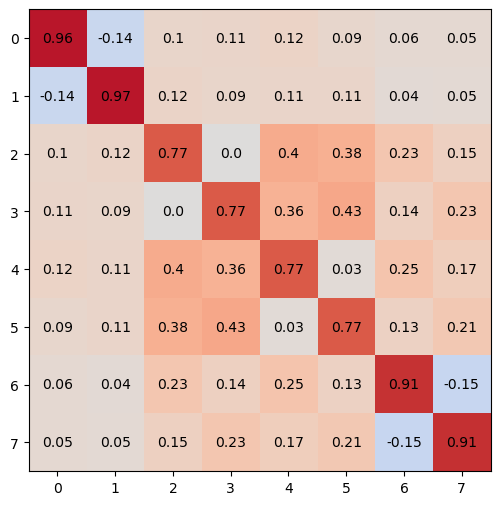

In [26]:
mat = A.T @ A_orth
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plt.imshow(mat, cmap='coolwarm', vmin = -1, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
plt.show()

In [27]:
Decoded_vars = (A.T @ Y).reshape(-1, n_trials, n_steps)
Decoded_vars = np.swapaxes(Decoded_vars, 1, 2)

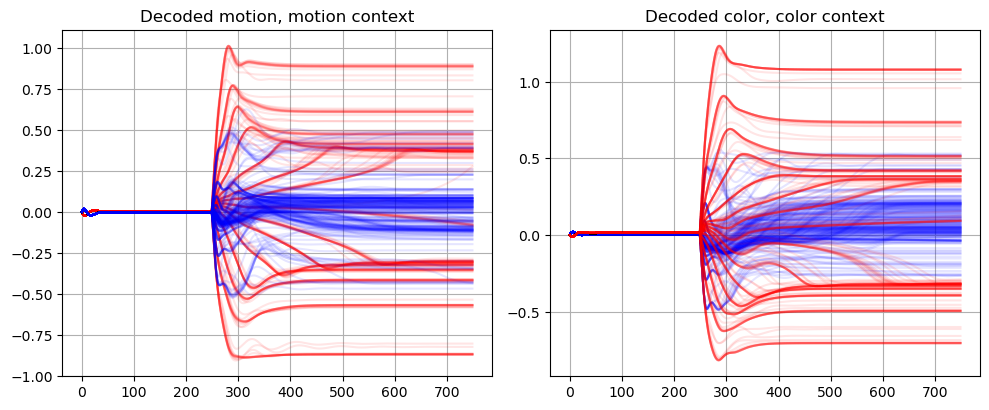

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(Decoded_vars[2, :, :225] - Decoded_vars[3, :, :225], color='r', alpha=0.1, label = 'relevant')
ax[0].plot(Decoded_vars[2, :, 225:] - Decoded_vars[3, :, 225:], color='b', alpha=0.1, label = 'irrelevant')
# ax[0].set_ylim([-15, 15])
ax[1].plot(Decoded_vars[4, :, :225] - Decoded_vars[5, :, :225], color='b', alpha=0.1)
ax[1].plot(Decoded_vars[4, :, 225:] - Decoded_vars[5, :, 225:], color='r', alpha=0.1)
# ax[1].set_ylim([-15, 15])

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax[0].title.set_text('Decoded motion, motion context')
ax[1].title.set_text('Decoded color, color context')
ax[0].grid(True)
ax[1].grid(True)
plt.show()

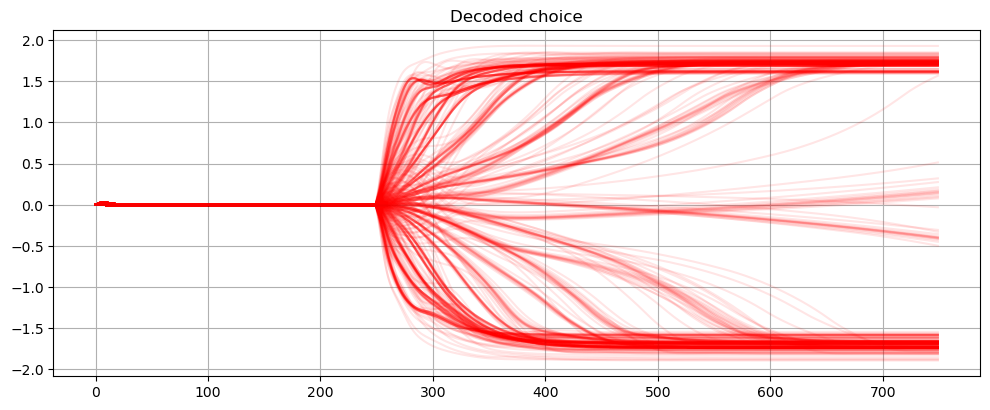

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(Decoded_vars[6, :, :] - Decoded_vars[7, :, :], color='r', alpha=0.1)
# ax[0].plot(, color='b', alpha=0.1)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax.title.set_text('Decoded choice')
ax.grid(True)
plt.show()

In [30]:
try:
    LA_data = pickle.load(open(os.path.join(RNN_path, f"{RNN_score}_LA_data.pkl"), "rb+"))
except:
    pass

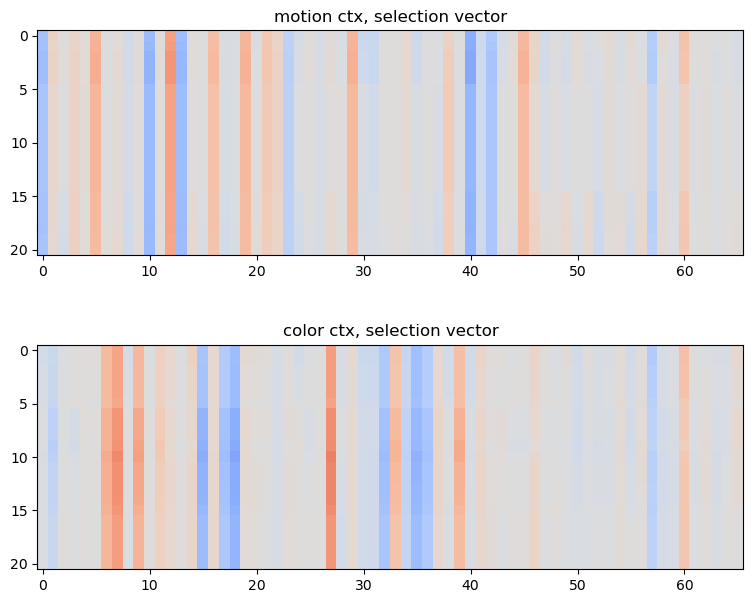

In [31]:
fig, ax = plt.subplots(2, 1, figsize = (16, 7))
ax[0].imshow(LA_data["motion"]["l"][5:-5, :], cmap='coolwarm', vmin = -1, vmax = 1)
ax[0].title.set_text('motion ctx, selection vector')
ax[1].imshow(LA_data["color"]["l"][5:-5, :], cmap='coolwarm', vmin = -1, vmax = 1)
ax[1].title.set_text('color ctx, selection vector')
# plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [32]:
avg_sv_motion = np.mean(LA_data["motion"]["l"][5:-5, :], axis = 0)
avg_sv_color = np.mean(LA_data["color"]["l"][5:-5, :], axis = 0)
avg_sv_motion /= np.linalg.norm(avg_sv_motion)
avg_sv_color /= np.linalg.norm(avg_sv_color)
Sv = np.hstack([avg_sv_motion.reshape(-1, 1), avg_sv_color.reshape(-1, 1)])

In [33]:
RNN_subfolder + f";tag={task_name}_relu;N=100;lmbdr={lmbdr};lmbdo={lmbdo}"

'0.0397083_CDDMplus;relu;N=66;lmbdo=0.3;lmbdr=0.3;lr=0.005;maxiter=3000;tag=CDDMplus_relu;N=100;lmbdr=0.3;lmbdo=0.3'

In [34]:
#Loading matrix Q
LC_folder = RNN_subfolder + f";tag={task_name}_relu;N=100;lmbdr={lmbdr};lmbdo={lmbdo}"
RNN_score = float(RNN_subfolder.split("_")[0])
RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", "CDDMplus", RNN_subfolder)
LC_folder_path = os.path.join('../', '../', "latent_circuit_inference", "data", "inferred_LCs", LC_folder)
subfolders = os.listdir(LC_folder_path)

ind = 0
max_score = -10
for i, subfolder in enumerate(subfolders):
    if "8nodes" in subfolder or "8-nodes" in subfolder:
        score = float(subfolder.split("_")[0])
        score_pr = float(subfolder.split("_")[1])
        if max_score <= score:
            max_score = score
            max_score_pr = score_pr
            ind = i 
LC_subfolder = subfolders[ind]
LC_path = os.path.join(LC_folder_path, LC_subfolder)
LC_data = json.load(open(os.path.join(LC_path, f"{max_score}_{max_score_pr}_LC_params.json"), "rb+"))
U = np.array(LC_data["U"])
q = np.array(LC_data["q"])
try:
    Q = U.T @ q
except:
    Q = (q @ U).T
w_out = np.array(LC_data["W_out"])
w_rec = np.array(LC_data["W_rec"])
w_inp = np.array(LC_data["W_inp"])
N = LC_data["N"]
dt = LC_data["dt"]
tau = LC_data["tau"]

print(f"Total variance explained: {np.round(max_score,2)}")
print(f"Projected variance explained: {np.round(max_score_pr,2)}")

Total variance explained: 0.84
Projected variance explained: 0.93


# Measuring correlations

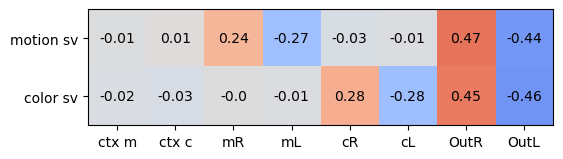

In [35]:
mat = (A.T @ Sv).T
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plt.imshow(mat, cmap='coolwarm', vmin = -0.7, vmax = 0.7)
ax.set_xticks(np.arange(8), ["ctx m", "ctx c", "mR", "mL", "cR", "cL", "OutR", "OutL"])
ax.set_yticks(np.arange(2), ["motion sv", "color sv"])
for (i, j), z in np.ndenumerate(mat):
    ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
plt.show()

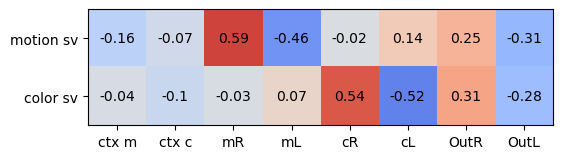

In [36]:
mat = (Q.T @ Sv).T
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plt.imshow(mat, cmap='coolwarm', vmin = -0.7, vmax = 0.7)
ax.set_xticks(np.arange(8), ["ctx m", "ctx c", "mR", "mL", "cR", "cL", "OutR", "OutL"])
ax.set_yticks(np.arange(2), ["motion sv", "color sv"])
for (i, j), z in np.ndenumerate(mat):
    ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
plt.show()

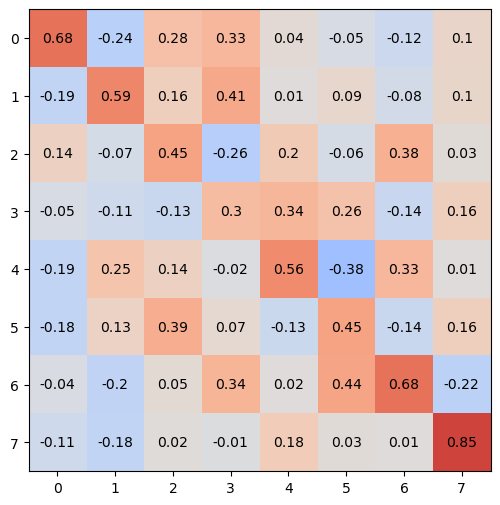

In [37]:
mat = Q.T @ A_orth
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plt.imshow(mat, cmap='coolwarm', vmin = -1, vmax = 1)
for (i, j), z in np.ndenumerate(mat):
    ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
plt.show()